<a href="https://colab.research.google.com/github/Aizaku-carcara/Identification-of-Flux-Ropes-in-Space-Plasma-Time-Series/blob/main/Source_Code_for_Flux_Rope_Identifier_vGH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plotting the Target Functions to be Correlated (TFC)...


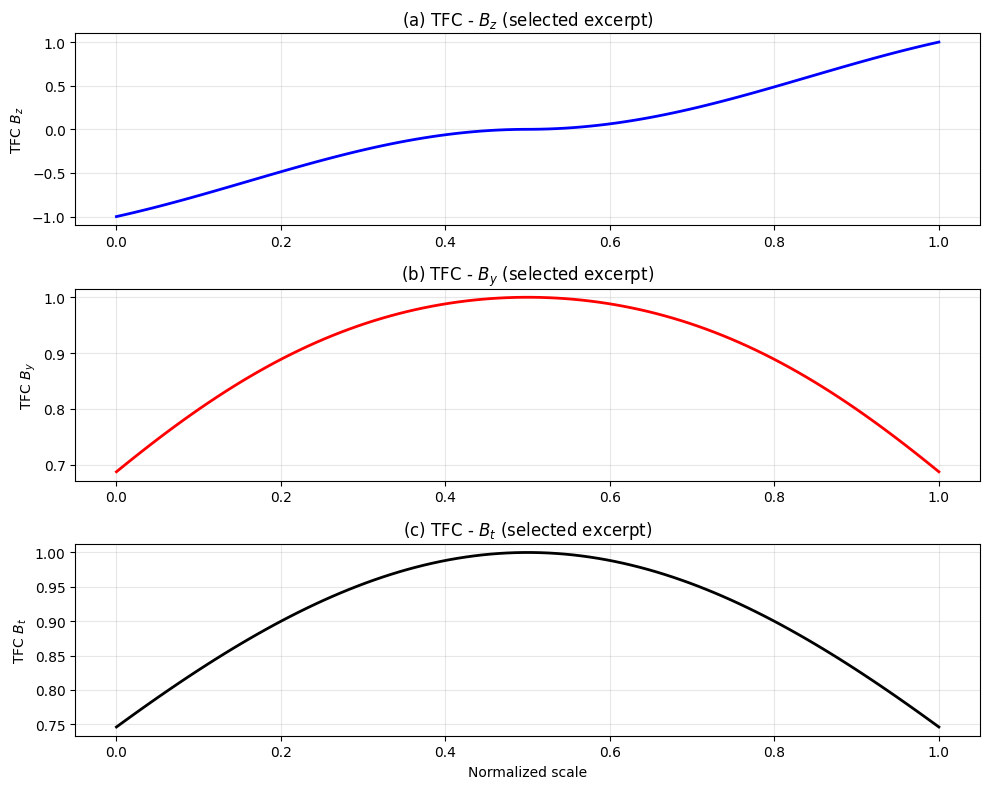

Plotting the detection results...


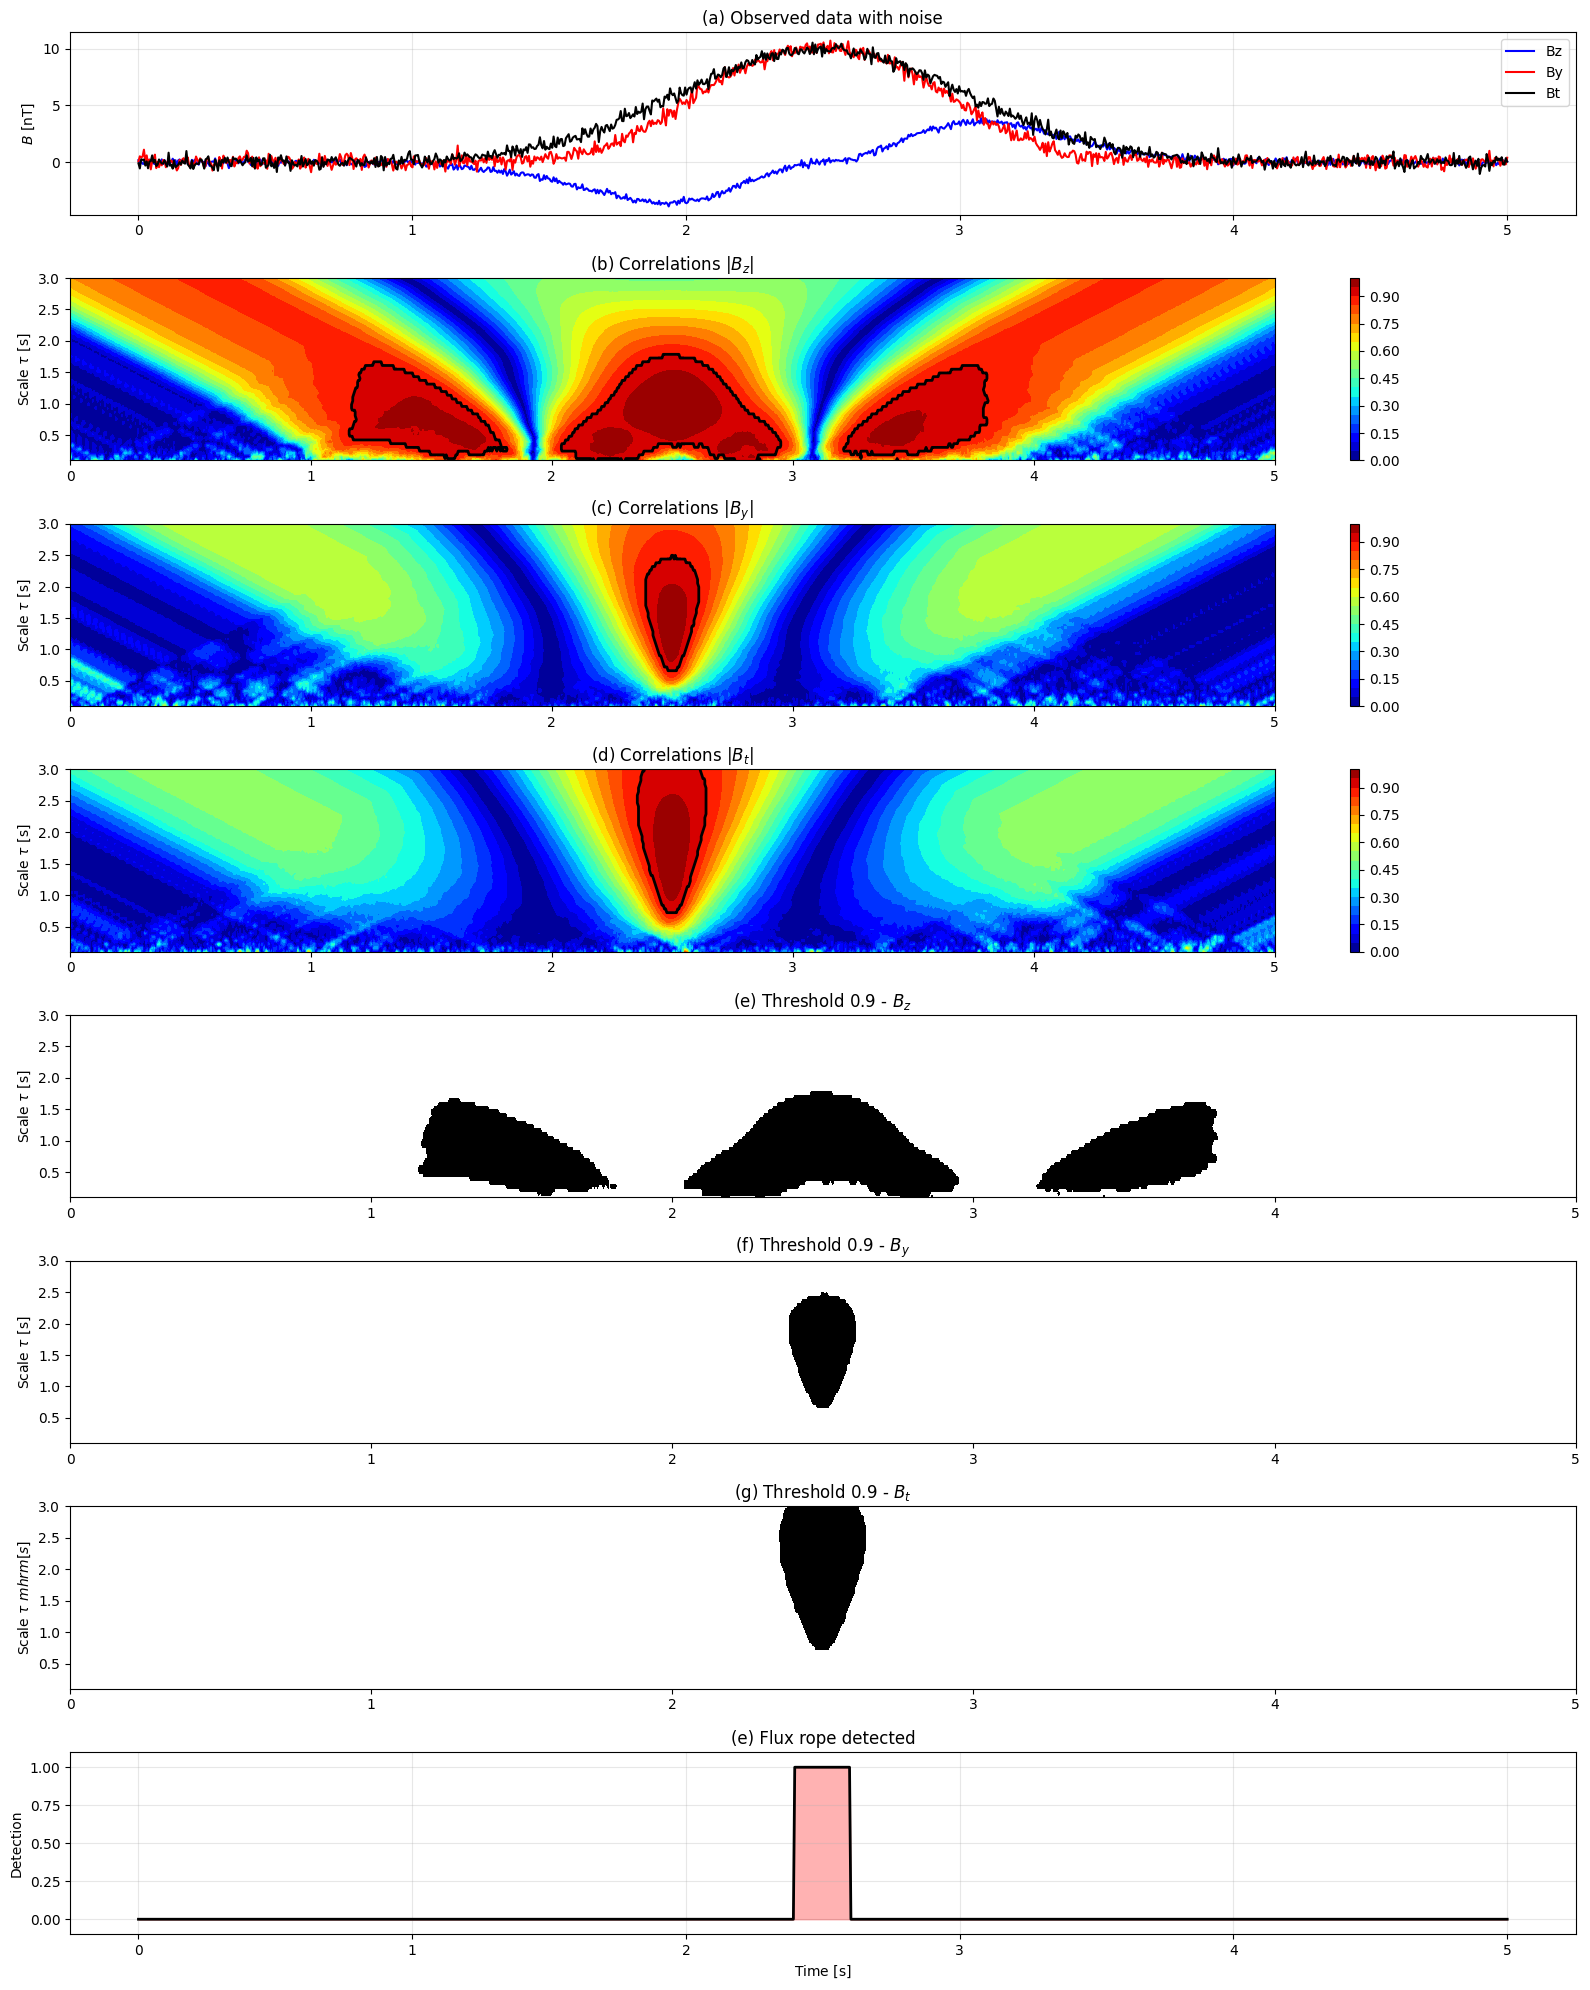


FLUX ROPE DETECTION STATISTICS
Number of events detected: 1

Event details:
------------------------------------------------------------

Event 1:
  Initial time: 2.397 s
  Final time: 2.598 s
  Central time: 2.497 s
  Duration: 0.200 s
  Estimated scale: 1.388 s
  Estimated amplitude: 7.19 nT
  Maximum correlation: 2.948
  Error in the center: 0.003 s


In [6]:
### Source Code for Flux Rope Identifier ###

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d

class FluxRopeDetector:
    """
    Implementation of the flux rope detection algorithm based on the article:
    "A new method to identify flux ropes in space plasmas" (Huang et al., 2018)
    """

    def __init__(self, threshold=0.9, sampling_rate=1.0):
        """
        Initializes the flux rope detector.

        Parameters:
        -----------
        threshold: float
          Threshold for correlation coefficients (default: 0.9)
        sampling_rate: float
          Data sampling rate (Hz) - points per second
        """
        self.threshold = threshold
        self.sampling_rate = sampling_rate
        self.tfc_bz = None
        self.tfc_by = None
        self.tfc_bt = None
        self.tfc_range = None  # Stores the range of the selected TFC

    def generate_elphic_russell_model(self, time_points, B0=10.0, a=0.735, b=0.735, center=2.5):
        """
        Generates synthetic Elphic-Russell (E-R) model data for flux ropes.

        Parameters:
        -----------
        time_points : array-like
          Time points for the simulation
        B0 : float
          Magnetic field amplitude (nT)
        a, b : float
          E-R model parameters
        center : float
          Center position of the flux rope

        Returns:
        --------
        dict : Dictionary with components Bz, By, Bt
        """
        t = np.array(time_points)
        r = np.abs(t - center)  # simplified radial distance

        # E-R model modified to 1D
        alpha = np.pi/2 * (1 - np.exp(-r**2/a**2))
        B_mag = B0 * np.exp(-r**2/b**2)

        # Components of the magnetic field
        By = B_mag * np.cos(alpha)
        Bz = B_mag * np.sin(alpha) * np.sign(t - center)
        Bt = np.sqrt(By**2 + Bz**2)

        return {'Bz': Bz, 'By': By, 'Bt': Bt, 'time': t}

    def add_noise(self, data, noise_level=0.1):
        """
        Adds noise to the data.

        Parameters:
        -----------
        data : dict
          Flux rope data
        noise_level : float
          Noise level (fraction of amplitude)

        Returns:
        --------
        dict : Data with added noise
        """
        noisy_data = {}
        for key, values in data.items():
            if key != 'time':
                noise = np.random.normal(0, noise_level * np.std(values), len(values))
                noisy_data[key] = values + noise
            else:
                noisy_data[key] = values

        return noisy_data

    def generate_tfc(self, scale_points=100, tfc_range=(-0.4, 0.4)):
        """
        Generates the Target Function to be Correlated (TFC) based on the E-R model.
        Selects only the representative section according to the paper.

        Parameters:
        -----------
        scale_points : int
          Number of points for the TFC
        tfc_range : tuple
          TFC range to be selected (default: bipolar region + nucleus)

        Returns:
        --------
        None : Stores the TFCs as class attributes
        """
        # Generate TFC in a larger range to then select
        full_scale = np.linspace(-1, 1, scale_points * 3)
        center = 0.0

        # Parameters of the E-R model for TFC given in the paper
        a = 0.735
        b = 0.735
        r = np.abs(full_scale - center)

        # Generates complete TFC
        alpha = np.pi/2 * (1 - np.exp(-r**2/a**2))
        B_mag = np.exp(-r**2/b**2)

        tfc_by_full = B_mag * np.cos(alpha)
        tfc_bz_full = B_mag * np.sin(alpha) * np.sign(full_scale - center)
        tfc_bt_full = np.sqrt(tfc_by_full**2 + tfc_bz_full**2)

        # Select only the representative section (bipolar region + nucleus)
        mask = (full_scale >= tfc_range[0]) & (full_scale <= tfc_range[1])
        selected_scale = full_scale[mask]

        # Resize to the desired number of points
        scale_normalized = np.linspace(0, 1, scale_points)

        self.tfc_by = np.interp(scale_normalized,
                               (selected_scale - selected_scale[0]) / (selected_scale[-1] - selected_scale[0]),
                               tfc_by_full[mask])
        self.tfc_bz = np.interp(scale_normalized,
                               (selected_scale - selected_scale[0]) / (selected_scale[-1] - selected_scale[0]),
                               tfc_bz_full[mask])
        self.tfc_bt = np.interp(scale_normalized,
                               (selected_scale - selected_scale[0]) / (selected_scale[-1] - selected_scale[0]),
                               tfc_bt_full[mask])

        # Normalize TFCs to unit amplitude (they will be rescaled later)
        self.tfc_by = self.tfc_by / np.max(self.tfc_by)
        self.tfc_bz = self.tfc_bz / np.max(np.abs(self.tfc_bz))
        self.tfc_bt = self.tfc_bt / np.max(self.tfc_bt)

        self.tfc_range = tfc_range

    def calculate_correlation_coefficients(self, data, scales):
        """
        Calculates the correlation coefficients between the data and the TFCs.
        Implementation corrected following the paper's algorithm.

        Parameters:
        -----------
        data: dict
          Observed data
        scales: array-like
          Time scales in seconds

        Returns:
        --------
        dict: Correlation coefficients for each component
        """
        time = data['time']
        bz = data['Bz']
        by = data['By']
        bt = data['Bt']

        # Generate TFC if not already generated
        if self.tfc_bz is None:
            self.generate_tfc()

        # Matrices to store correlations (with and without absolute value)
        corr_bz = np.zeros((len(time), len(scales)))
        corr_by = np.zeros((len(time), len(scales)))
        corr_bt = np.zeros((len(time), len(scales)))

        # Correlations with preserved sign (for later estimates)
        corr_bz_signed = np.zeros((len(time), len(scales)))
        corr_by_signed = np.zeros((len(time), len(scales)))
        corr_bt_signed = np.zeros((len(time), len(scales)))

        for i, center_time in enumerate(time):
            for j, scale in enumerate(scales):
                if scale <= 0:
                    continue

                half_window_points = int(scale * self.sampling_rate / 2)

                # Defines time window in indexes
                start_idx = max(0, i - half_window_points)
                end_idx = min(len(time), i + half_window_points + 1)

                if end_idx - start_idx < 3:
                    continue

                # Extract segment from data
                segment_bz = bz[start_idx:end_idx]
                segment_by = by[start_idx:end_idx]
                segment_bt = bt[start_idx:end_idx]

                # Resize TFC to segment size
                tfc_length = len(segment_bz)
                if tfc_length > 1:
                    tfc_bz_resized = np.interp(np.linspace(0, 1, tfc_length),
                                             np.linspace(0, 1, len(self.tfc_bz)),
                                             self.tfc_bz)
                    tfc_by_resized = np.interp(np.linspace(0, 1, tfc_length),
                                             np.linspace(0, 1, len(self.tfc_by)),
                                             self.tfc_by)
                    tfc_bt_resized = np.interp(np.linspace(0, 1, tfc_length),
                                             np.linspace(0, 1, len(self.tfc_bt)),
                                             self.tfc_bt)

                    bt_amplitude = np.max(segment_bt) if np.max(segment_bt) > 0 else 1.0
                    tfc_bz_scaled = tfc_bz_resized * bt_amplitude
                    tfc_by_scaled = tfc_by_resized * bt_amplitude
                    tfc_bt_scaled = tfc_bt_resized * bt_amplitude

                    # Normalize segments (subtract mean and divide by deviation)
                    if np.std(segment_bz) > 0:
                        segment_bz_norm = (segment_bz - np.mean(segment_bz)) / np.std(segment_bz)
                        tfc_bz_norm = (tfc_bz_scaled - np.mean(tfc_bz_scaled)) / np.std(tfc_bz_scaled)
                        corr_coef = np.corrcoef(segment_bz_norm, tfc_bz_norm)[0, 1]
                        corr_bz_signed[i, j] = corr_coef
                        corr_bz[i, j] = abs(corr_coef)

                    if np.std(segment_by) > 0:
                        segment_by_norm = (segment_by - np.mean(segment_by)) / np.std(segment_by)
                        tfc_by_norm = (tfc_by_scaled - np.mean(tfc_by_scaled)) / np.std(tfc_by_scaled)
                        corr_coef = np.corrcoef(segment_by_norm, tfc_by_norm)[0, 1]
                        corr_by_signed[i, j] = corr_coef
                        corr_by[i, j] = abs(corr_coef)

                    if np.std(segment_bt) > 0:
                        segment_bt_norm = (segment_bt - np.mean(segment_bt)) / np.std(segment_bt)
                        tfc_bt_norm = (tfc_bt_scaled - np.mean(tfc_bt_scaled)) / np.std(tfc_bt_scaled)
                        corr_coef = np.corrcoef(segment_bt_norm, tfc_bt_norm)[0, 1]
                        corr_bt_signed[i, j] = corr_coef
                        corr_bt[i, j] = abs(corr_coef)

        corr_bz = np.nan_to_num(corr_bz)
        corr_by = np.nan_to_num(corr_by)
        corr_bt = np.nan_to_num(corr_bt)
        corr_bz_signed = np.nan_to_num(corr_bz_signed)
        corr_by_signed = np.nan_to_num(corr_by_signed)
        corr_bt_signed = np.nan_to_num(corr_bt_signed)

        return {
            'Bz': corr_bz, 'By': corr_by, 'Bt': corr_bt,
            'Bz_signed': corr_bz_signed, 'By_signed': corr_by_signed, 'Bt_signed': corr_bt_signed
        }

    def identify_flux_ropes(self, data, scales):
        """
        Identifies flux ropes based on correlation coefficients.
        Implementation fixed with quantitative estimates.

        Parameters:
        -----------
        data: dict
          Observed data
        scales: array-like
          Time scales in seconds

        Returns:
        --------
        dict: Information about detected flux ropes, including estimates
        """
        correlations = self.calculate_correlation_coefficients(data, scales)

        # Find regions with high correlation
        high_corr_bz = correlations['Bz'] > self.threshold
        high_corr_by = correlations['By'] > self.threshold
        high_corr_bt = correlations['Bt'] > self.threshold

        # Flux rope detected when all three components have high correlation
        flux_rope_mask = high_corr_bz & high_corr_by & high_corr_bt

        # Find connected regions
        detection_array = np.zeros(len(data['time']))
        estimated_scales = np.zeros(len(data['time']))
        estimated_amplitudes = np.zeros(len(data['time']))

        if np.any(flux_rope_mask):
            for i in range(len(data['time'])):
                if np.any(flux_rope_mask[i, :]):
                    detection_array[i] = 1

                    # Calculates combined weights
                    weights = (correlations['Bz'][i, :] +
                              correlations['By'][i, :] +
                              correlations['Bt'][i, :])
                    valid_scales = flux_rope_mask[i, :]

                    if np.any(valid_scales) and np.sum(weights[valid_scales]) > 0:
                        # Weighted average of the scale
                        estimated_scales[i] = np.sum(weights[valid_scales] * scales[valid_scales]) / np.sum(weights[valid_scales])

                        # Amplitude estimation based on maximum correlation
                        max_corr_idx = np.argmax(weights[valid_scales])
                        scale_idx = np.where(valid_scales)[0][max_corr_idx]

                        # Estimate Bt amplitude at the optimal scale
                        scale_opt = scales[scale_idx]
                        half_window_points = int(scale_opt * self.sampling_rate / 2)
                        start_idx = max(0, i - half_window_points)
                        end_idx = min(len(data['time']), i + half_window_points + 1)

                        if end_idx > start_idx:
                            bt_segment = data['Bt'][start_idx:end_idx]
                            estimated_amplitudes[i] = np.max(bt_segment) - np.min(bt_segment)

        # Identifies ongoing events and calculates statistics
        flux_rope_events = []
        if np.any(detection_array > 0):
            # Find connected regions
            diff_detection = np.diff(np.concatenate(([0], detection_array, [0])))
            starts = np.where(diff_detection == 1)[0]
            ends = np.where(diff_detection == -1)[0]

            for start, end in zip(starts, ends):
                if end > start:
                    event_indices = np.arange(start, end)
                    event_weights = (correlations['Bz'][event_indices, :] +
                                   correlations['By'][event_indices, :] +
                                   correlations['Bt'][event_indices, :])

                    # Find point of maximum correlation
                    max_corr_flat = np.argmax(event_weights)
                    max_time_idx, max_scale_idx = np.unravel_index(max_corr_flat, event_weights.shape)
                    max_time_idx += start

                    # Weighted average of event estimates
                    event_scales = estimated_scales[event_indices]
                    event_amplitudes = estimated_amplitudes[event_indices]
                    valid_event = event_scales > 0

                    if np.any(valid_event):
                        avg_scale = np.mean(event_scales[valid_event])
                        avg_amplitude = np.mean(event_amplitudes[valid_event])

                        flux_rope_events.append({
                            'start_time': data['time'][start],
                            'end_time': data['time'][end-1],
                            'center_time': data['time'][max_time_idx],
                            'duration': data['time'][end-1] - data['time'][start],
                            'estimated_scale': avg_scale,
                            'estimated_amplitude': avg_amplitude,
                            'max_correlation': np.max(event_weights)
                        })

        return {
            'detection_array': detection_array,
            'correlations': correlations,
            'flux_rope_mask': flux_rope_mask,
            'estimated_scales': estimated_scales,
            'estimated_amplitudes': estimated_amplitudes,
            'flux_rope_events': flux_rope_events
        }

    def plot_results(self, data, scales, results):
        """
        Plot the detection results (reproduces Figure 5).

        Parameters:
        -----------
        data: dict
          Observed data
        scales: array-like
          Temporal scales
        results: dict
          Detection results
        """
        fig, axes = plt.subplots(8, 1, figsize=(16, 20))

        time = data['time']
        correlations = results['correlations']
        flux_rope_mask = results['flux_rope_mask']

        axes[0].plot(time, data['Bz'], 'b-', label='Bz', linewidth=1.5)
        axes[0].plot(time, data['By'], 'r-', label='By', linewidth=1.5)
        axes[0].plot(time, data['Bt'], 'k-', label='Bt', linewidth=1.5)
        axes[0].set_ylabel('$B~\mathrm{[nT]}$')
        axes[0].legend()
        axes[0].set_title('(a) Observed data with noise')
        axes[0].grid(True, alpha=0.3)

        im1 = axes[1].contourf(time, scales, correlations['Bz'].T, levels=20, cmap='jet')
        axes[1].contour(time, scales, (correlations['Bz'] > self.threshold).T, levels=[0.5], colors='black', linewidths=2)
        axes[1].set_ylabel('Scale $\\tau~\mathrm{[s]}$')
        axes[1].set_title('(b) Correlations $\\vert B_{z}\\vert$')
        plt.colorbar(im1, ax=axes[1])

        im2 = axes[2].contourf(time, scales, correlations['By'].T, levels=20, cmap='jet')
        axes[2].contour(time, scales, (correlations['By'] > self.threshold).T, levels=[0.5], colors='black', linewidths=2)
        axes[2].set_ylabel('Scale $\\tau~\mathrm{[s]}$')
        axes[2].set_title('(c) Correlations $\\vert B_{y}\\vert$')
        plt.colorbar(im2, ax=axes[2])

        im3 = axes[3].contourf(time, scales, correlations['Bt'].T, levels=20, cmap='jet')
        axes[3].contour(time, scales, (correlations['Bt'] > self.threshold).T, levels=[0.5], colors='black', linewidths=2)
        axes[3].set_ylabel('Scale $\\tau~\mathrm{[s]}$')
        axes[3].set_title('(d) Correlations $\\vert B_{t}\\vert$')
        plt.colorbar(im3, ax=axes[3])

        threshold_mask_bz = correlations['Bz'] > self.threshold
        axes[4].contourf(time, scales, threshold_mask_bz.T, levels=[0.5, 1.5], colors=['black'])
        axes[4].set_ylabel('Scale $\\tau~\mathrm{[s]}$')
        axes[4].set_title(f'(e) Threshold {self.threshold} - $B_z$')

        threshold_mask_by = correlations['By'] > self.threshold
        axes[5].contourf(time, scales, threshold_mask_by.T, levels=[0.5, 1.5], colors=['black'])
        axes[5].set_ylabel('Scale $\\tau~\mathrm{[s]}$')
        axes[5].set_title(f'(f) Threshold {self.threshold} - $B_y$')

        threshold_mask_bt = correlations['Bt'] > self.threshold
        axes[6].contourf(time, scales, threshold_mask_bt.T, levels=[0.5, 1.5], colors=['black'])
        axes[6].set_ylabel('Scale $\\tau~m\thrm{[s]}$')
        axes[6].set_title(f'(g) Threshold {self.threshold} - $B_t$')

        axes[7].plot(time, results['detection_array'], 'k-', linewidth=2)
        axes[7].fill_between(time, results['detection_array'], alpha=0.3, color='red')
        axes[7].set_ylabel('Detection')
        axes[7].set_xlabel('Time $\mathrm{[s]}$')
        axes[7].set_title('(e) Flux rope detected')
        axes[7].set_ylim(-0.1, 1.1)
        axes[7].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return fig

    def plot_tfc(self):
        """
        Plots the Target Functions to be Correlated (TFC).
        """
        if self.tfc_bz is None:
            self.generate_tfc()

        fig, axes = plt.subplots(3, 1, figsize=(10, 8))
        scale_points = np.linspace(0, 1, len(self.tfc_bz))

        axes[0].plot(scale_points, self.tfc_bz, 'b-', linewidth=2)
        axes[0].set_ylabel('TFC $B_{z}$')
        axes[0].set_title('(a) TFC - $B_{z}$ (selected excerpt)')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(scale_points, self.tfc_by, 'r-', linewidth=2)
        axes[1].set_ylabel('TFC $B_{y}$')
        axes[1].set_title('(b) TFC - $B_{y}$ (selected excerpt)')
        axes[1].grid(True, alpha=0.3)

        axes[2].plot(scale_points, self.tfc_bt, 'k-', linewidth=2)
        axes[2].set_ylabel('TFC $B_{t}$')
        axes[2].set_xlabel('Normalized scale')
        axes[2].set_title('(c) TFC - $B_{t}$ (selected excerpt)')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return fig

    def print_detection_statistics(self, results, data):
        """
        Prints detailed detection statistics.
        """
        print("\n" + "="*60)
        print("FLUX ROPE DETECTION STATISTICS")
        print("="*60)

        events = results['flux_rope_events']

        if len(events) == 0:
            print("No flux rope detected!")
            return

        print(f"Number of events detected: {len(events)}")
        print("\nEvent details:")
        print("-" * 60)

        for i, event in enumerate(events):
            print(f"\nEvent {i+1}:")
            print(f"  Initial time: {event['start_time']:.3f} s")
            print(f"  Final time: {event['end_time']:.3f} s")
            print(f"  Central time: {event['center_time']:.3f} s")
            print(f"  Duration: {event['duration']:.3f} s")
            print(f"  Estimated scale: {event['estimated_scale']:.3f} s")
            print(f"  Estimated amplitude: {event['estimated_amplitude']:.2f} nT")
            print(f"  Maximum correlation: {event['max_correlation']:.3f}")

            # Comparison with real values (assuming center at 2.5s)
            if 'center_time' in event:
                center_error = abs(event['center_time'] - 2.5)
                print(f"  Error in the center: {center_error:.3f} s")

# Usage example
if __name__ == "__main__":
    # Initialize the detector with sampling rate
    time_points = np.linspace(0, 5, 1000)
    dt = time_points[1] - time_points[0]
    sampling_rate = 1.0 / dt  # Hz

    detector = FluxRopeDetector(threshold=0.9, sampling_rate=sampling_rate)

    # Generates synthetic data (E-R model)
    clean_data = detector.generate_elphic_russell_model(time_points, B0=10.0, center=2.5)

    # Adds noise (10%)
    noisy_data = detector.add_noise(clean_data, noise_level=0.1)

    # Sets scales for analysis (in seconds)
    scales = np.linspace(0.1, 3.0, 50)

    results = detector.identify_flux_ropes(noisy_data, scales)

    print("Plotting the Target Functions to be Correlated (TFC)...")
    detector.plot_tfc()

    print("Plotting the detection results...")
    detector.plot_results(noisy_data, scales, results)

    detector.print_detection_statistics(results, noisy_data)